We will use January flight data from 2019 and 2020 from Kaggle in order to predict whether or not a flight arrived 15 minutes or more past its expected time. This is treated as a binary variable where 1 indicates that there was a delayed arrival and 0 indicates that there was not

To start we load the 2 datasets and concatenate them into a single Pandas dataframe

In [234]:
import pandas as pd
import numpy as np
import datetime

In [235]:
df_2019 = pd.read_csv('Jan_2019_ontime.csv')
df_2020 = pd.read_csv('Jan_2020_ontime.csv')
df = pd.concat([df_2019, df_2020])

In [236]:
df.head()

,DAY_OF_MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,OP_CARRIER_AIRLINE_ID,OP_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN_AIRPORT_SEQ_ID,ORIGIN,...,DEST,DEP_TIME,DEP_DEL15,DEP_TIME_BLK,ARR_TIME,ARR_DEL15,CANCELLED,DIVERTED,DISTANCE,Unnamed: 21
0,1,2,9E,20363,9E,N8688C,3280,11953,1195302,GNV,...,ATL,601.0,0.0,0600-0659,722.0,0.0,0.0,0.0,300.0,NaN
1,1,2,9E,20363,9E,N348PQ,3281,13487,1348702,MSP,...,CVG,1359.0,0.0,1400-1459,1633.0,0.0,0.0,0.0,596.0,NaN
2,1,2,9E,20363,9E,N8896A,3282,11433,1143302,DTW,...,CVG,1215.0,0.0,1200-1259,1329.0,0.0,0.0,0.0,229.0,NaN
3,1,2,9E,20363,9E,N8886A,3283,15249,1524906,TLH,...,ATL,1521.0,0.0,1500-1559,1625.0,0.0,0.0,0.0,223.0,NaN
4,1,2,9E,20363,9E,N8974C,3284,10397,1039707,ATL,...,FSM,1847.0,0.0,1900-1959,1940.0,0.0,0.0,0.0,579.0,NaN


In [237]:
df = df.drop(columns = ['Unnamed: 21']) #remove random column full of NaN values

Let's start by looking at some summary statistics

In [238]:
np.mean(df['ARR_DEL15']) #percent of flights that arrived late

0.18591674720785634

In [239]:
print(df.isna().sum()) #looking at the number of NaN values in each column

DAY_OF_MONTH                 0
DAY_OF_WEEK                  0
OP_UNIQUE_CARRIER            0
OP_CARRIER_AIRLINE_ID        0
OP_CARRIER                   0
TAIL_NUM                  2543
OP_CARRIER_FL_NUM            0
ORIGIN_AIRPORT_ID            0
ORIGIN_AIRPORT_SEQ_ID        0
ORIGIN                       0
DEST_AIRPORT_ID              0
DEST_AIRPORT_SEQ_ID          0
DEST                         0
DEP_TIME                 16352
DEP_DEL15                16355
DEP_TIME_BLK                 0
ARR_TIME                 17061
ARR_DEL15                18022
CANCELLED                    0
DIVERTED                     0
DISTANCE                     0
dtype: int64


In [240]:
df.info() #some general information about the types of each column

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 583985 entries, 0 to 583984
Data columns (total 21 columns):
DAY_OF_MONTH             583985 non-null int64
DAY_OF_WEEK              583985 non-null int64
OP_UNIQUE_CARRIER        583985 non-null object
OP_CARRIER_AIRLINE_ID    583985 non-null int64
OP_CARRIER               583985 non-null object
TAIL_NUM                 581442 non-null object
OP_CARRIER_FL_NUM        583985 non-null int64
ORIGIN_AIRPORT_ID        583985 non-null int64
ORIGIN_AIRPORT_SEQ_ID    583985 non-null int64
ORIGIN                   583985 non-null object
DEST_AIRPORT_ID          583985 non-null int64
DEST_AIRPORT_SEQ_ID      583985 non-null int64
DEST                     583985 non-null object
DEP_TIME                 567633 non-null float64
DEP_DEL15                567630 non-null float64
DEP_TIME_BLK             583985 non-null object
ARR_TIME                 566924 non-null float64
ARR_DEL15                565963 non-null float64
CANCELLED                5839

To start with, we can get rid of columns that we aren't concerned with predicting. This would be flight cancellations and diversions.

In [241]:
df = df.drop(columns = ['CANCELLED', 'DIVERTED'])

In [242]:
df.nunique()

DAY_OF_MONTH               31
DAY_OF_WEEK                 7
OP_UNIQUE_CARRIER          17
OP_CARRIER_AIRLINE_ID      17
OP_CARRIER                 17
TAIL_NUM                 5446
OP_CARRIER_FL_NUM        6839
ORIGIN_AIRPORT_ID         346
ORIGIN_AIRPORT_SEQ_ID     346
ORIGIN                    346
DEST_AIRPORT_ID           346
DEST_AIRPORT_SEQ_ID       346
DEST                      346
DEP_TIME                 1438
DEP_DEL15                   2
DEP_TIME_BLK               19
ARR_TIME                 1440
ARR_DEL15                   2
DISTANCE                 1451
dtype: int64

The "SEQ" ID's seem to be repeats of the original ID's but with some extra values. For now we will drop those

In [243]:
df = df.drop(columns = ['ORIGIN_AIRPORT_SEQ_ID', 'DEST_AIRPORT_SEQ_ID'])

TAIL_NUM is not usable, so we'll drop this, as with the flight number

In [244]:
df = df.drop(columns = ['TAIL_NUM', 'OP_CARRIER_FL_NUM'])

We can now look more closely at each of the features we've held onto, starting with the month and week

In [245]:
df.groupby('DAY_OF_MONTH')['ARR_DEL15'].mean()

DAY_OF_MONTH
1     0.215423
2     0.257957
3     0.186185
4     0.127087
5     0.160788
6     0.198471
7     0.151579
8     0.101620
9     0.103387
10    0.143248
11    0.160589
12    0.150572
13    0.162158
14    0.151467
15    0.154934
16    0.129132
17    0.200223
18    0.219003
19    0.201091
20    0.210049
21    0.269010
22    0.225870
23    0.272890
24    0.311952
25    0.226672
26    0.133417
27    0.188134
28    0.178465
29    0.145864
30    0.204032
31    0.208535
Name: ARR_DEL15, dtype: float64

I thought there might be a situation where there are more delays on January 1st, but this seems to not be true and no clear trends are present, likely because we are combining years. Day of week might be more helpful

In [246]:
df.groupby('DAY_OF_WEEK')['ARR_DEL15'].mean()

DAY_OF_WEEK
1    0.186837
2    0.167916
3    0.193716
4    0.209893
5    0.183462
6    0.160310
7    0.189246
Name: ARR_DEL15, dtype: float64

Seems to be true that weekend flights have more delays so we'll create a new variable seeing if the flight was on a weekend day, which means Thursday, Friday, Saturday, or Sunday

In [123]:
df['WEEKEND'] = np.where(df['DAY_OF_WEEK'] >= 4, 1, 0)

Next, let's look at information about the carriers

In [124]:
df.groupby('OP_CARRIER')['ARR_DEL15'].mean()

OP_CARRIER
9E    0.152609
AA    0.166344
AS    0.192720
B6    0.210430
DL    0.116493
EV    0.204775
F9    0.190671
G4    0.227485
HA    0.111522
MQ    0.220905
NK    0.145848
OH    0.186357
OO    0.188282
UA    0.163482
WN    0.122972
YV    0.182086
YX    0.174024
Name: ARR_DEL15, dtype: float64

It's difficult to number these but the carrier does seem to matter, so we'll turn it into a category type and drop the other carrier variables

In [125]:
df['OP_CARRIER'] = df['OP_CARRIER'].astype('category')
df = df.drop(columns = ['OP_UNIQUE_CARRIER', 'OP_CARRIER_AIRLINE_ID'])

In [126]:
df.nunique()

DAY_OF_MONTH           31
DAY_OF_WEEK             7
OP_CARRIER             17
ORIGIN_AIRPORT_ID     353
ORIGIN                353
DEST_AIRPORT_ID       353
DEST                  353
DEP_TIME             1440
DEP_DEL15               2
DEP_TIME_BLK           19
ARR_TIME             1440
ARR_DEL15               2
DISTANCE             1512
WEEKEND                 2
dtype: int64

In [127]:
df_mean_bydest = df.groupby('DEST')['ARR_DEL15'].mean()
df_count_bydest = df.groupby('DEST')['ARR_DEL15'].count()

In [128]:
df_mean_bydest = pd.DataFrame(df_mean_bydest)
df_count_bydest = pd.DataFrame(df_count_bydest)

In [129]:
df_mean_bydest.columns = ['Mean_Delayed']
df_count_bydest.columns = ['Count']

In [130]:
df_bydest = df_mean_bydest.join(df_count_bydest)

In [131]:
df_bydest.sort_values(by = 'Mean_Delayed', ascending = False)

,Mean_Delayed,Count
DEST,,
MKG,0.353535,99
OGD,0.352941,17
ASE,0.343266,1678
RIW,0.340000,50
OGS,0.338983,59
...,...,...
ATY,0.053571,56
CPR,0.052326,172
BTM,0.051724,116


In [132]:
df_bydest[df_bydest['Mean_Delayed'] > 0.25].shape

(34, 2)

25% delayed seems like a natural breaking point so we'll create a new variables called DEST_DELAY_PRONE with a 1 for the destinations in this group

In [133]:
dest_list = df_bydest[df_bydest['Mean_Delayed'] > 0.25].index

In [134]:
dest_list = np.asarray(dest_list)
df['DELAY_PRONE'] = df['DEST'].apply(lambda x: x in dest_list)
df['DELAY_PRONE'] = df['DELAY_PRONE'].astype(int)

In [135]:
df.nunique()

DAY_OF_MONTH           31
DAY_OF_WEEK             7
OP_CARRIER             17
ORIGIN_AIRPORT_ID     353
ORIGIN                353
DEST_AIRPORT_ID       353
DEST                  353
DEP_TIME             1440
DEP_DEL15               2
DEP_TIME_BLK           19
ARR_TIME             1440
ARR_DEL15               2
DISTANCE             1512
WEEKEND                 2
DELAY_PRONE             2
dtype: int64

We can now get rid of the columns related to the destination airport

In [136]:
df = df.drop(columns = ['DEST_AIRPORT_ID', 'DEST'])
df.nunique()

DAY_OF_MONTH           31
DAY_OF_WEEK             7
OP_CARRIER             17
ORIGIN_AIRPORT_ID     353
ORIGIN                353
DEP_TIME             1440
DEP_DEL15               2
DEP_TIME_BLK           19
ARR_TIME             1440
ARR_DEL15               2
DISTANCE             1512
WEEKEND                 2
DELAY_PRONE             2
dtype: int64

We can follow a similar process for the origin airport now.

In [137]:
df_mean_byorig = df.groupby('ORIGIN')['ARR_DEL15'].mean()
df_count_byorig = df.groupby('ORIGIN')['ARR_DEL15'].count()

In [138]:
df_mean_byorig = pd.DataFrame(df_mean_byorig)
df_count_byorig = pd.DataFrame(df_count_byorig)

In [139]:
df_mean_byorig.columns = ['Mean_Delayed']
df_count_byorig.columns = ['Count']

In [140]:
df_byorig = df_mean_byorig.join(df_count_byorig)

In [141]:
df_byorig.sort_values(by = 'Mean_Delayed', ascending = False)

,Mean_Delayed,Count
ORIGIN,,
SHR,0.486486,37
OGD,0.411765,17
PSM,0.372549,51
HGR,0.363636,22
ASE,0.359069,1632
...,...,...
ITO,0.060217,1013
PIR,0.053571,56
BTM,0.051724,116


In [142]:
df_byorig[df_byorig['Mean_Delayed'] > 0.25].shape

(39, 2)

In [143]:
orig_list = df_byorig[df_byorig['Mean_Delayed'] > 0.25].index
orig_list = np.asarray(orig_list)
df['DELAY_PRONE_ORIG'] = df['ORIGIN'].apply(lambda x: x in orig_list)
df['DELAY_PRONE_ORIG'] = df['DELAY_PRONE_ORIG'].astype(int)

In [144]:
df.nunique()

DAY_OF_MONTH           31
DAY_OF_WEEK             7
OP_CARRIER             17
ORIGIN_AIRPORT_ID     353
ORIGIN                353
DEP_TIME             1440
DEP_DEL15               2
DEP_TIME_BLK           19
ARR_TIME             1440
ARR_DEL15               2
DISTANCE             1512
WEEKEND                 2
DELAY_PRONE             2
DELAY_PRONE_ORIG        2
dtype: int64

Once again can now get rid of the other origin related variables

In [145]:
df = df.drop(columns = ['ORIGIN_AIRPORT_ID', 'ORIGIN'])

In [146]:
df.nunique()

DAY_OF_MONTH          31
DAY_OF_WEEK            7
OP_CARRIER            17
DEP_TIME            1440
DEP_DEL15              2
DEP_TIME_BLK          19
ARR_TIME            1440
ARR_DEL15              2
DISTANCE            1512
WEEKEND                2
DELAY_PRONE            2
DELAY_PRONE_ORIG       2
dtype: int64

Let's look at distance now. My intuition is that the longer the flight, the more likely the flight is to arrive delayed.

In [152]:
df['ARR_DEL15'].corr(df['DISTANCE'])

0.006920237443392367

Correlation is lower than expected but we'll leave the column as is for now. Next let's look at the departure time block.

In [154]:
df.groupby('DEP_TIME_BLK')['ARR_DEL15'].mean()

DEP_TIME_BLK
0001-0559    0.104384
0600-0659    0.098793
0700-0759    0.115250
0800-0859    0.130838
0900-0959    0.134258
1000-1059    0.152312
1100-1159    0.152182
1200-1259    0.160066
1300-1359    0.166544
1400-1459    0.180077
1500-1559    0.180803
1600-1659    0.190362
1700-1759    0.197569
1800-1859    0.206462
1900-1959    0.199627
2000-2059    0.197690
2100-2159    0.179697
2200-2259    0.160995
2300-2359    0.148177
Name: ARR_DEL15, dtype: float64

We want to have a similar variable, ARR_TIME_BLK for the arrival times, so let's create this here

In [156]:
def timeToBlock(t): #function taken from notebook seen on kaggle 
    block="NaN"
    if(t> 0 and t< 600): block="0001-0559"
    if(t>559 and t< 700): block= "0600-0659"
    if(t>659 and t< 800): block= "0700-0759"
    if(t>759 and t< 900): block= "0800-0859"
    if(t>859 and t< 1000): block= "0900-0959"
    if(t>959 and t< 1100): block= "1000-1059"
    if(t>1059 and t< 1200): block= "1100-1159"
    if(t>1159 and t< 1300): block= "1200-1259"
    if(t>1259 and t< 1400): block= "1300-1359"
    if(t>1359 and t< 1500): block= "1400-1459"
    if(t>1459 and t< 1600): block= "1500-1559"
    if(t>1559 and t< 1700): block= "1600-1659"
    if(t>1659 and t< 1800): block="1700-1759"
    if(t>1759 and t< 1900): block= "1800-1859"
    if(t>1859 and t< 2000): block= "1900-1959"
    if(t>1959 and t< 2100): block= "2000-2059"
    if(t>2059 and t< 2200): block= "2100-2159"
    if(t>2159 and t< 2300): block= "2200-2259"
    if(t>2259 and t< 2400): block="2300-2359"
    return block

In [157]:
df['ARR_TIME_BLK']=df['ARR_TIME'].apply(timeToBlock)

In [158]:
df.groupby('ARR_TIME_BLK')['ARR_DEL15'].mean()

ARR_TIME_BLK
0001-0559    0.392467
0600-0659    0.062625
0700-0759    0.048975
0800-0859    0.067707
0900-0959    0.094912
1000-1059    0.112623
1100-1159    0.124808
1200-1259    0.134370
1300-1359    0.133826
1400-1459    0.152402
1500-1559    0.150482
1600-1659    0.157231
1700-1759    0.182098
1800-1859    0.183441
1900-1959    0.196598
2000-2059    0.195241
2100-2159    0.203641
2200-2259    0.232466
2300-2359    0.228357
Nan          0.306368
Name: ARR_DEL15, dtype: float64

Although departure time seems to play a slight role, it is far omore pronounced in the arrival time block.

In [159]:
df.nunique()

DAY_OF_MONTH          31
DAY_OF_WEEK            7
OP_CARRIER            17
DEP_TIME            1440
DEP_DEL15              2
DEP_TIME_BLK          19
ARR_TIME            1440
ARR_DEL15              2
DISTANCE            1512
WEEKEND                2
DELAY_PRONE            2
DELAY_PRONE_ORIG       2
ARR_TIME_BLK          20
dtype: int64

In [161]:
df = df.drop(columns = ['DEP_TIME', 'DEP_DEL15', 'ARR_TIME', 'DAY_OF_MONTH', 'DAY_OF_WEEK'])
df.nunique()

KeyError: "['DEP_TIME' 'DEP_DEL15' 'ARR_TIME' 'DAY_OF_MONTH' 'DAY_OF_WEEK'] not found in axis"

In [163]:
df.groupby('ARR_TIME_BLK')['ARR_DEL15'].mean()

ARR_TIME_BLK
0001-0559    0.392467
0600-0659    0.062625
0700-0759    0.048975
0800-0859    0.067707
0900-0959    0.094912
1000-1059    0.112623
1100-1159    0.124808
1200-1259    0.134370
1300-1359    0.133826
1400-1459    0.152402
1500-1559    0.150482
1600-1659    0.157231
1700-1759    0.182098
1800-1859    0.183441
1900-1959    0.196598
2000-2059    0.195241
2100-2159    0.203641
2200-2259    0.232466
2300-2359    0.228357
Nan          0.306368
Name: ARR_DEL15, dtype: float64

Since we will need to one hot encode the time blocks, I want to try and reduce the number of categories. For arrival time block, I will use "Early morning", "daytime", "night". But first, we haven't dropped NaN columns yet so let's do that here.

In [164]:
print(df.shape)
df = df.dropna()
print(df.shape)

(1191331, 8)
(1165231, 8)


In [166]:
def blockToCategory(t): #function taken from notebook seen on kaggle 
    block="NaN"
    if(t == "0001-0559"): block="early morning"
    if(t == "0600-0659" or t == "0700-0759" or t == "0800-0859" or t == "0900-0959" or t ==  "1000-1059" or t == "1100-1159"):block="morning"
    if(t == "1200-1259" or t == "1300-1359" or t ==  "1400-1459" or t == "1500-1559" or t == "1600-1659"):block="afternoon"
    if(t== "1700-1759" or t == "1800-1859" or t == "1900-1959" or t == "2000-2059"):block = "early evening"
    if(t == "2100-2159" or t == "2200-2259" or t == "2300-2359"):block = "late evening"
    return block

In [167]:
df['ARR_TIME_CAT']=df['ARR_TIME_BLK'].apply(blockToCategory)

/Users/dshenker/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [172]:
df.head()

,OP_CARRIER,DEP_TIME_BLK,ARR_DEL15,DISTANCE,WEEKEND,DELAY_PRONE,DELAY_PRONE_ORIG,ARR_TIME_BLK,ARR_TIME_CAT,DEP_TIME_CAT
0,9E,0600-0659,0.0,300.0,0,0,0,0700-0759,morning,morning
1,9E,1400-1459,0.0,596.0,0,0,0,1600-1659,afternoon,afternoon
2,9E,1200-1259,0.0,229.0,0,0,0,1300-1359,afternoon,afternoon
3,9E,1500-1559,0.0,223.0,0,0,0,1600-1659,afternoon,afternoon
4,9E,1900-1959,0.0,579.0,0,0,0,1900-1959,early evening,early evening


In [171]:
df['DEP_TIME_CAT'] = df['DEP_TIME_BLK'].apply(blockToCategory)

/Users/dshenker/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [175]:
df.nunique()

OP_CARRIER            17
ARR_DEL15              2
DISTANCE            1511
WEEKEND                2
DELAY_PRONE            2
DELAY_PRONE_ORIG       2
ARR_TIME_CAT           6
DEP_TIME_CAT           5
dtype: int64

In [174]:
df = df.drop(columns = ['DEP_TIME_BLK', 'ARR_TIME_BLK'])

We are now ready to do the modeling, which will be done using a Random Forest Classifier. First we need to onehotencode some of our columns

In [232]:
from sklearn.preprocessing import LabelEncoder 
from sklearn.preprocessing import OneHotEncoder 
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt

In [182]:
df['ARR_TIME_CAT'] = df['ARR_TIME_CAT'].astype('category')
df['DEP_TIME_CAT'] = df['DEP_TIME_CAT'].astype('category')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1165231 entries, 0 to 607345
Data columns (total 8 columns):
OP_CARRIER          1165231 non-null category
ARR_DEL15           1165231 non-null float64
DISTANCE            1165231 non-null float64
WEEKEND             1165231 non-null int64
DELAY_PRONE         1165231 non-null int64
DELAY_PRONE_ORIG    1165231 non-null int64
ARR_TIME_CAT        1165231 non-null category
DEP_TIME_CAT        1165231 non-null category
dtypes: category(3), float64(2), int64(3)
memory usage: 56.7 MB


In [198]:
labelencoder = LabelEncoder()
enc = OneHotEncoder()
df = df.reset_index()
df['OP_CARRIER'] = labelencoder.fit_transform(df['OP_CARRIER'])
df['ARR_TIME_CAT'] = labelencoder.fit_transform(df['ARR_TIME_CAT'])
df['DEP_TIME_CAT'] = labelencoder.fit_transform(df['DEP_TIME_CAT'])


carrier_encoded = pd.DataFrame(enc.fit_transform(df[['OP_CARRIER']]).toarray())
carrier_encoded.columns = enc.get_feature_names(['OP_CARRIER'])

arr_time_encoded = pd.DataFrame(enc.fit_transform(df[['ARR_TIME_CAT']]).toarray())
arr_time_encoded.columns = enc.get_feature_names(['ARR_TIME_CAT'])

dep_time_encoded = pd.DataFrame(enc.fit_transform(df[['DEP_TIME_CAT']]).toarray())
dep_time_encoded.columns = enc.get_feature_names(['DEP_TIME_CAT'])


/Users/dshenker/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/Users/dshenker/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "cate

In [204]:
df_new = df.join(carrier_encoded)
df_new = df_new.join(arr_time_encoded)
df_new = df_new.join(dep_time_encoded)

In [209]:
df_new

,index,OP_CARRIER,ARR_DEL15,DISTANCE,WEEKEND,DELAY_PRONE,DELAY_PRONE_ORIG,ARR_TIME_CAT,DEP_TIME_CAT,OP_CARRIER_0.0,...,ARR_TIME_CAT_1.0,ARR_TIME_CAT_2.0,ARR_TIME_CAT_3.0,ARR_TIME_CAT_4.0,ARR_TIME_CAT_5.0,DEP_TIME_CAT_0.0,DEP_TIME_CAT_1.0,DEP_TIME_CAT_2.0,DEP_TIME_CAT_3.0,DEP_TIME_CAT_4.0
0,0,0,0.0,300.0,0,0,0,5,4,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,1,0,0.0,596.0,0,0,0,1,0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,2,0,0.0,229.0,0,0,0,1,0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,3,0,0.0,223.0,0,0,0,1,0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,4,0,0.0,579.0,0,0,0,2,1,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1165226,607341,0,1.0,443.0,1,0,0,5,4,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1165227,607342,0,0.0,509.0,1,0,0,2,1,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1165228,607343,0,0.0,610.0,1,1,0,5,4,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1165229,607344,0,0.0,589.0,1,0,0,2,1,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [210]:
df_new.columns

Index(['index', 'OP_CARRIER', 'ARR_DEL15', 'DISTANCE', 'WEEKEND',
       'DELAY_PRONE', 'DELAY_PRONE_ORIG', 'ARR_TIME_CAT', 'DEP_TIME_CAT',
       'OP_CARRIER_0.0', 'OP_CARRIER_1.0', 'OP_CARRIER_2.0', 'OP_CARRIER_3.0',
       'OP_CARRIER_4.0', 'OP_CARRIER_5.0', 'OP_CARRIER_6.0', 'OP_CARRIER_7.0',
       'OP_CARRIER_8.0', 'OP_CARRIER_9.0', 'OP_CARRIER_10.0',
       'OP_CARRIER_11.0', 'OP_CARRIER_12.0', 'OP_CARRIER_13.0',
       'OP_CARRIER_14.0', 'OP_CARRIER_15.0', 'OP_CARRIER_16.0',
       'ARR_TIME_CAT_0.0', 'ARR_TIME_CAT_1.0', 'ARR_TIME_CAT_2.0',
       'ARR_TIME_CAT_3.0', 'ARR_TIME_CAT_4.0', 'ARR_TIME_CAT_5.0',
       'DEP_TIME_CAT_0.0', 'DEP_TIME_CAT_1.0', 'DEP_TIME_CAT_2.0',
       'DEP_TIME_CAT_3.0', 'DEP_TIME_CAT_4.0'],
      dtype='object')

In [211]:
df_new = df_new.drop(columns = ['index', 'OP_CARRIER', 'ARR_TIME_CAT', 'DEP_TIME_CAT'])

We now can do our train test split and apply the random forest classifier

In [223]:
import sklearn.model_selection as model_selection
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

In [214]:
X = df_new.drop(columns = ['ARR_DEL15'])
y = df_new['ARR_DEL15']
[X_train, X_test, y_train, y_test] = model_selection.train_test_split(X, y, train_size=0.7,test_size=0.3, random_state=101)

In [226]:
clf= RandomForestClassifier(random_state=0, n_estimators = 20)
clf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=40,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [227]:
clf.score(X_test, y_test)

0.852332866092628

In [228]:
print(confusion_matrix(y_test, clf.predict(X_test)))

[[288015   5730]
 [ 45890   9935]]


In [230]:
feature_importance = clf.feature_importances_

Text(0.5, 1.0, 'Feature Importance (MDI)')

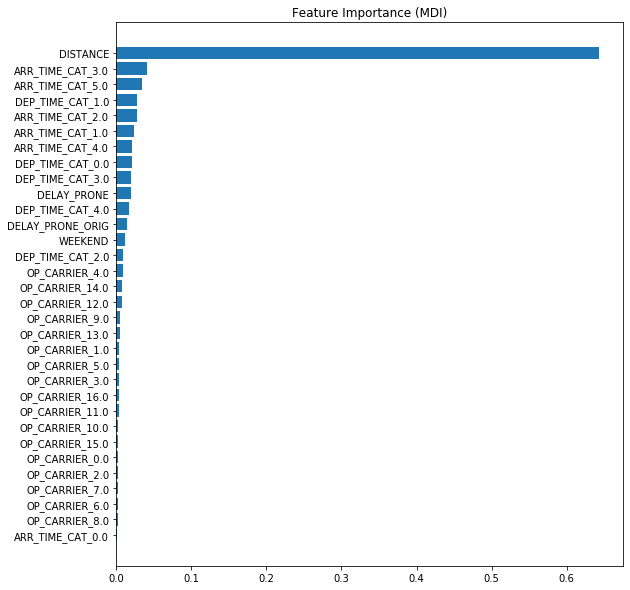

In [233]:
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(X_train.columns)[sorted_idx])
plt.title('Feature Importance (MDI)')